In [7]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import itertools as it
import calcs as c
import pickle

## Subproject 1

<b>Problem 1</b>: For a 3 $\times$ 3 lattice, there are $2^9$ configurations possible.

In [8]:
configs = 2**9
print("There are " + str(configs) + " configurations.")

There are 512 configurations.


<b>Problem 2:</b> The code for this is found in the <i>calcs.py</i> file and enumerates all possible configurations.

In [9]:
# creating the lattice (code is in the calcs.py file)
lattices = c.create_lattices()

In [10]:
# Here is a sample
print(lattices[:, :, 100])

[[ 1.  1. -1.]
 [-1.  1.  1.]
 [-1.  1.  1.]]


<b>Problem 3:</b> The code for this is given by the functions "hammy" and "nn" in the <i>calcs.py</i> file.

<b>Problem 4:</b> Using the code in <b>3</b> to calculate the partition function and internal energy of the lattice at $T=0.1$ K and $T=1000$ K.

In [11]:
J, H = 1.0, 0.0
T = [0.1, 1000.0]
Q_lo_T, avg_lo = c.get_Q_and_E(0.1, 1.0, 0.0, lattices)
Q_hi_T, avg_hi = c.get_Q_and_E(1000.0, 1.0, 0.0, lattices)

In [12]:
print("The average energy in the low temperature regime is " + str(avg_lo)[0:9] + ".")
print("The average energy in the high temperature regime is " + str(avg_hi)[0:9] + ".")
print("The partition function in the low temperature regime is "
      + str(Q_lo_T)[0:9] + str(Q_lo_T)[-4:] + ".")
print("The partition function in the high temperature regime is " + str(Q_hi_T)[0:9] + ".")

The average energy in the low temperature regime is -18.0.
The average energy in the high temperature regime is -0.018018.
The partition function in the low temperature regime is 2.9787684e+78.
The partition function in the high temperature regime is 512.00461.


<b>Explanation:</b> In the low $T$ limit, I would expect $Q$ to blow up to infinity as we are summing exponentials with exponents dependent on inverse temperature. In the high $T$ limit, I would expect $Q$ to approach $512$ because $1/kT \rightarrow 0$ as $T \rightarrow \infty$, making $Q$ approximately equivalent to adding $1$ to itself $512$ times. These results are in agreement with this mathematical argument.

## Subproject 2

<b>Problem 1</b>: Energy calculation using Onsager's solution for the internal energy of infinitely sized lattices. The expression used was
\begin{align*}
    U = - J \coth(2 \beta J) \left[ 1 + \dfrac{2}{\pi} \left( 2 \tanh^2(2 \beta J) - 1 \right) \int_0^{\pi/2}  \dfrac{{\rm d}\theta}{\sqrt{1-4k(1+k)^{-2}\sin^2\theta}} \right],
\end{align*}
where
\begin{align*}
    k = {\rm csch}^2(2 \beta J).
\end{align*}

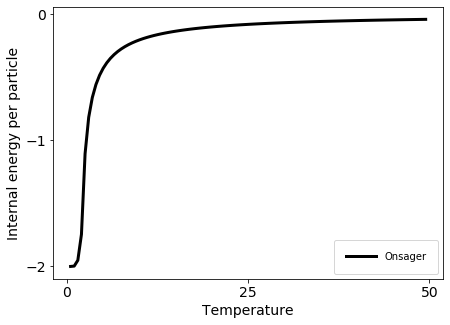

In [13]:
J = 1.0
T, E = c.onsager(J)
E_plt_list = [E]
c.plt_onsager(T, E_plt_list, "Onsager.pdf")

<b>Problem 2</b>: Calculating the enrgy per particle of the $3 \times 3$ lattice and comparing these data to Onsager's solution found in <i>Problem 1</i>.

In [14]:
E_array = np.zeros_like(T, float)
print(T.shape)
for k in range(T.shape[-1]):
    Temp = T[k]
    E_array[k] = c.get_Q_and_E(Temp, 1.0, 0.0, lattices, True)[1]

(99,)


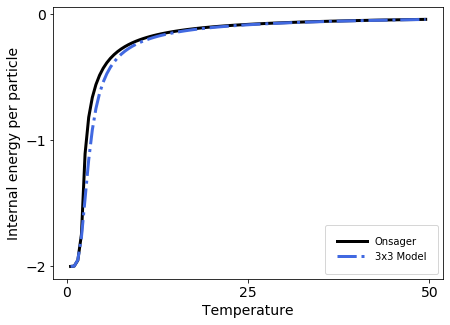

In [15]:
E_plt_list.append(E_array)
c.plt_onsager(T, E_plt_list, "OnsagerVs3x3.pdf")

## Subproject 3

<b>Problem 1</b>: The <i>rnd()</i> function in <i>calcs.py</i> returns either $-1$ or $+1$ at random. The code is explained within the function docstring.

In [16]:
print(c.rnd())

-1


<b>Problem 2</b>: The <i>rndN()</i> function in <i>calcs.py</i> returns two random integers $i$ and $j$ that are between 0 and $N$, where $N \times N$ is the size of the lattice.

In [17]:
print(c.rndN(10))

(8, 0)


## MCMC algorithm

In [59]:
def MCMC(params):
    # unpack the dictionary
    dim, kb, Temp, J, H, n_iter = params.values()
    beta = 1.0 / (kb * Temp)
    J *= kb
    H = 0.0

    # create the empty lists
    E_bar = []
    M_bar = []

    # get initial lattice and create a copy
    # maybe try init_indx=511
    init_indx = c.rndN(configs)[0]
    x1 = lattices[:, :, init_indx]
    assert(lattices.shape[0] is dim)
    

    for k in range(n_iter):

        # create a copy of the lattice
        x2 = x1

        # select random spin
        i, j = c.rndN(dim-1)
        x2[i, j] *= -1.0

        # get the hammies
        x1_ham = c.hammy(J, H, x1)
        x2_ham = c.hammy(J, H, x2)

        # random number between 0 and 1
        u = random.uniform(0, 1)
        temp = -beta * (x2_ham - x1_ham)
        val = np.exp(temp)

        if (u < val):
            # retain c'
            mag = np.sum(x2)
            E_bar.append(x2_ham)
            M_bar.append(mag)
            x1 = x2

        else:
            # retain c
            mag = np.sum(x1)
            E_bar.append(x1_ham)
            M_bar.append(mag)

    return np.array(E_bar), np.array(M_bar)

In [61]:
# Sanity check: comparison to results from subproject 1
Ts = [0.1, 1000]
words = ["low temp E:", "high temp E:"]
for k in range(2):
    params = {"dim":3, "kb":1.0, "Temperature":Ts[k],
              "J":1.0, "H":0.0, "n_iter":10000}
    E, M = MCMC(params)
    avg_E = np.sum(E) / E.shape[0]
    print(words[k], avg_E)
print("-------------------")

low temp E: 0.1932
high temp E: 0.1048
-------------------


<b>Problem 4</b>: Sampling the $3 \times 3$ lattice with $J = k_{\rm B}$, $H=0$, and $T=10$. These parameters are loaded into the params dictionary and then passed to the MCMC function.

In [65]:
params = {"dim":3, "kb":1.0, "Temperature":10.0,
          "J":1.0, "H":0.0, "n_iter":10000}
E, M = MCMC(params)
avg_E = np.sum(E) / E.shape[0]
print(avg_E)

-0.044


<b>Problem 5</b>: Running code for a $10 \times 10$ lattice. The function called <i>rnd_lattice()</i> creates a random $N \times N$ lattice and is found in the <i>calcs.py</i> file. 

In [73]:
# create a random 10 x 10 lattice
bit_lettuce = c.rnd_lattice(N)

AttributeError: module 'calcs' has no attribute 'rnd_lattice'

[[ 0. -2.  2.  0.  2. -2. -2.  0. -2. -2.]
 [ 2. -2.  0.  0.  0. -2.  0.  2.  0.  2.]
 [ 0.  0. -2.  0.  0. -2.  0. -2. -2.  0.]
 [ 0.  2.  0.  0.  0. -2.  0. -2.  2. -2.]
 [-2.  0.  2. -2.  2.  0.  0. -2.  0.  2.]
 [ 0. -2.  2. -2. -2.  0.  0. -2.  0. -2.]
 [ 0.  2.  0.  0. -2.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0. -2.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  2.  2.  0.  2.  0.  0. -2.]
 [ 0. -2. -2.  0.  0.  2.  0.  0.  0. -2.]]


In [4]:
# computing the number of configurations
dim = 10
dd = 10 * 10
configs = 2**dd

In [ ]:
big_lettuce = c.create_lattices(10)

In [ ]:
with open(f"large_lattice.pkl", "rb") as f:
    large_lettuce = pickle.load(f)

In [40]:
print
print(np.sum(E)/E.shape[0])

0.056


In [27]:
print(E)

[-2. -2. -2.  2.  6.  6. -2. -2. -2. -2.]


In [24]:
config_index

NameError: name 'config_index' is not defined

In [ ]:
dim = 3
kb = 1.0
Temp = 10.0
beta = 1.0 / (kb * Temp)
J = kb
H = 0.0
E_bar = []
M_bar = []
init_indx = c.rndN(configs)[0]
lat_at_i = lattices[:, :, init_indx]
temp_lat = lat_at_i

# select random spin
i, j = c.rndN(dim-1)
temp_lat[i, j] *= -1.0
ham_new_i = 

# get the hammies
ham_at_i = c.hammy(J, H, lat_at_i)
temp_ham_i = c.hammy(J, H, temp_lat)

# random number between 0 and 1
u = random.uniform(0, 1)
temp = -beta * (temp_ham_i - ham_at_i)
val = np.exp(temp)

if (u < val):
    # retain c'
    mag = np.sum(temp_lat)
    E_bar.append(temp_ham_i)
    M_bar.append(mag)

else:
    mag = np.sum(lat_at_i)
    E_bar.append(ham_at_i)
    M_bar.append(mag)